In [1]:
!ls ../input/sneaker-dataset

'Sneaker Dataset'


In [2]:
!pwd

/kaggle/working


In [3]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as tfs
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from numpy import transpose, array
import torchvision.transforms.functional as TF

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
class Critic(nn.Module):
    def __init__(self):
        super().__init__()

        self.crit = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(256, affine=True), # affine=True makes params learnable
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(0.2),

            # Output here - 16*16*512

            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=16, stride=1, padding=0)
        )


    def forward(self, x):
        return self.crit(x)


class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.gen = nn.Sequential(
           nn.ConvTranspose2d(in_channels=64, out_channels=512, kernel_size=16, stride=1, padding=0),
           nn.BatchNorm2d(512),
           nn.ReLU(),

           nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
           nn.BatchNorm2d(256),
           nn.ReLU(),

           nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
           nn.BatchNorm2d(128),
           nn.ReLU(),

           nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
           nn.BatchNorm2d(64),
           nn.ReLU(),

           nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
           nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)




def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02) # normal distribution with mean 0 and std dev 0.02

In [6]:
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1) # L2 norm
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)

    return gradient_penalty

def plot_generated_images():
    noise = torch.randn(25, 64, 1, 1).to(device)
    fake = gen(noise)

    # Convert tensor to PIL images and renormalize
    fake_images = [(TF.to_pil_image((img * 0.5) + 0.5)) for img in fake]

    print(array(fake_images[5]))
    # Plot the images
    for i in range(25):
      plt.subplot(5, 5, 1 + i)
      plt.axis('off')

      plt.imshow(fake_images[i])

    plt.savefig(f"/kaggle/working/results_{epoch+1}.png")
    plt.show()


Folder loaded
Training started
Epoch [0/300] Loss D: -1104.3882, loss G: 558.8839
Epoch [1/300] Loss D: -2621.0962, loss G: 1500.4603
Epoch [2/300] Loss D: -3308.7163, loss G: 2187.2759
Epoch [3/300] Loss D: -3162.4893, loss G: 2550.8811
Epoch [4/300] Loss D: -2817.7341, loss G: 2621.6143
Epoch [5/300] Loss D: -2543.2690, loss G: 2621.7749
Epoch [6/300] Loss D: -2320.4897, loss G: 2704.3711
Epoch [7/300] Loss D: -2075.7495, loss G: 2397.4636
Epoch [8/300] Loss D: -1665.9163, loss G: 2248.5996
Epoch [9/300] Loss D: -1366.2476, loss G: 2094.8435
Epoch [10/300] Loss D: -1151.6953, loss G: 1918.8671
Epoch [11/300] Loss D: -903.7093, loss G: 1854.6879
Epoch [12/300] Loss D: -674.4329, loss G: 1676.2456
Epoch [13/300] Loss D: -542.6783, loss G: 1683.7439
Epoch [14/300] Loss D: -423.5269, loss G: 1861.8928
Epoch [15/300] Loss D: -304.6197, loss G: 1701.2371
Epoch [16/300] Loss D: -286.2993, loss G: 1658.6512
Epoch [17/300] Loss D: -189.3947, loss G: 1552.5184
Epoch [18/300] Loss D: -219.7683,

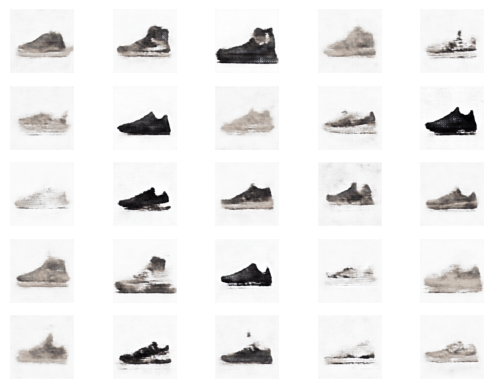

Epoch [25/300] Loss D: -157.6064, loss G: 1464.2028
Epoch [26/300] Loss D: -130.7165, loss G: 1521.9374
Epoch [27/300] Loss D: -166.4357, loss G: 1545.5355
Epoch [28/300] Loss D: -147.0104, loss G: 1423.0458
Epoch [29/300] Loss D: -133.0385, loss G: 1403.8881
Epoch [30/300] Loss D: -129.0182, loss G: 1475.5708
Epoch [31/300] Loss D: -157.3286, loss G: 1440.9117
Epoch [32/300] Loss D: -147.6124, loss G: 1335.5033
Epoch [33/300] Loss D: -129.0738, loss G: 1318.8645
Epoch [34/300] Loss D: -103.3213, loss G: 1358.7660
Epoch [35/300] Loss D: -106.3565, loss G: 1390.9802
Epoch [36/300] Loss D: -115.1824, loss G: 1279.9557
Epoch [37/300] Loss D: -160.8288, loss G: 1280.2084
Epoch [38/300] Loss D: -151.0175, loss G: 1370.7001
Epoch [39/300] Loss D: -144.5299, loss G: 1230.7054
Epoch [40/300] Loss D: -144.4549, loss G: 1309.2980
Epoch [41/300] Loss D: -134.2029, loss G: 1264.6272
Epoch [42/300] Loss D: -123.8202, loss G: 1213.1644
Epoch [43/300] Loss D: -116.8769, loss G: 1337.5336
Epoch [44/30

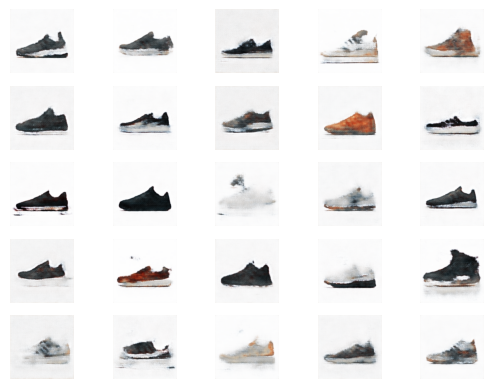

Epoch [50/300] Loss D: -130.7355, loss G: 1202.5355
Epoch [51/300] Loss D: -102.8582, loss G: 1278.6901
Epoch [52/300] Loss D: -208.0140, loss G: 1215.7673
Epoch [53/300] Loss D: -112.4837, loss G: 1224.2141
Epoch [54/300] Loss D: -102.1132, loss G: 1233.4639
Epoch [55/300] Loss D: -119.5478, loss G: 1241.9124
Epoch [56/300] Loss D: -182.5213, loss G: 1177.2081
Epoch [57/300] Loss D: -67.0358, loss G: 1208.5394
Epoch [58/300] Loss D: -145.8074, loss G: 1241.0536
Epoch [59/300] Loss D: -83.7984, loss G: 1196.2963
Epoch [60/300] Loss D: -134.4727, loss G: 1306.3395
Epoch [61/300] Loss D: -103.4825, loss G: 1251.9305
Epoch [62/300] Loss D: -164.2560, loss G: 1353.7133
Epoch [63/300] Loss D: -119.0766, loss G: 1127.9901
Epoch [64/300] Loss D: -105.6051, loss G: 1199.8995
Epoch [65/300] Loss D: -107.7343, loss G: 1252.8239
Epoch [66/300] Loss D: -117.9952, loss G: 1300.7931
Epoch [67/300] Loss D: -92.4678, loss G: 1172.3491
Epoch [68/300] Loss D: -128.3966, loss G: 1233.7701
Epoch [69/300] 

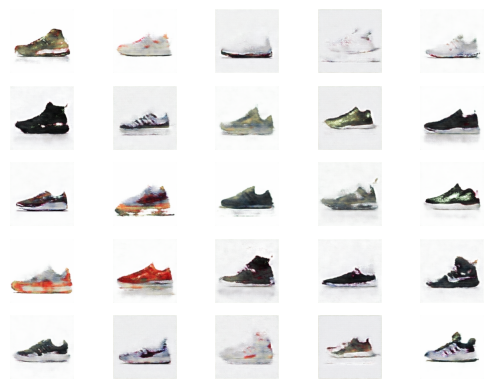

Epoch [75/300] Loss D: -118.7028, loss G: 1209.1353
Epoch [76/300] Loss D: -75.4766, loss G: 1206.9910
Epoch [77/300] Loss D: -184.1267, loss G: 1242.4698
Epoch [78/300] Loss D: -95.0598, loss G: 1186.6038
Epoch [79/300] Loss D: -156.1894, loss G: 1188.5842
Epoch [80/300] Loss D: -84.7880, loss G: 1179.4722
Epoch [81/300] Loss D: -95.8052, loss G: 1155.2373
Epoch [82/300] Loss D: -96.2120, loss G: 1213.5829
Epoch [83/300] Loss D: -138.3141, loss G: 1060.8704
Epoch [84/300] Loss D: -127.1888, loss G: 1102.4775
Epoch [85/300] Loss D: -110.2021, loss G: 1214.9595
Epoch [86/300] Loss D: -111.8393, loss G: 1210.6217
Epoch [87/300] Loss D: -101.2332, loss G: 1119.4503
Epoch [88/300] Loss D: -132.1723, loss G: 1075.2562
Epoch [89/300] Loss D: -139.8575, loss G: 1214.9099
Epoch [90/300] Loss D: -122.6072, loss G: 1199.1008
Epoch [91/300] Loss D: -153.6873, loss G: 1226.2467
Epoch [92/300] Loss D: -124.1149, loss G: 1159.5806
Epoch [93/300] Loss D: -116.8196, loss G: 1158.3136
Epoch [94/300] Lo

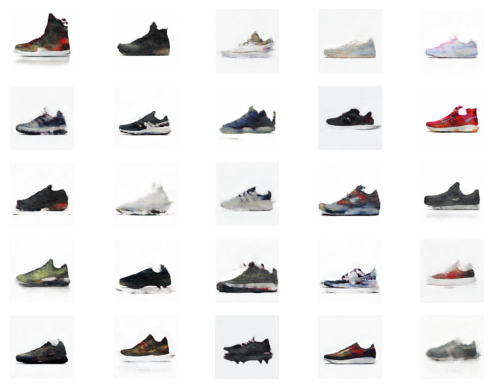

Epoch [100/300] Loss D: -125.0167, loss G: 1102.1512
Epoch [101/300] Loss D: -97.0238, loss G: 1213.8904
Epoch [102/300] Loss D: -98.5295, loss G: 1154.4375
Epoch [103/300] Loss D: -122.9821, loss G: 1144.9526
Epoch [104/300] Loss D: -119.5640, loss G: 1209.8490
Epoch [105/300] Loss D: -130.1896, loss G: 1035.2260
Epoch [106/300] Loss D: -126.3288, loss G: 1230.1808
Epoch [107/300] Loss D: -124.6688, loss G: 1190.0623
Epoch [108/300] Loss D: -91.0403, loss G: 1166.6089
Epoch [109/300] Loss D: -97.8248, loss G: 1252.6407
Epoch [110/300] Loss D: -104.7258, loss G: 1074.6946
Epoch [111/300] Loss D: -129.1541, loss G: 1056.3632
Epoch [112/300] Loss D: -164.0193, loss G: 1102.0586
Epoch [113/300] Loss D: -100.2129, loss G: 1077.6957
Epoch [114/300] Loss D: -99.2728, loss G: 1185.4685
Epoch [115/300] Loss D: -84.3249, loss G: 1234.6488
Epoch [116/300] Loss D: -109.3224, loss G: 1186.4349
Epoch [117/300] Loss D: -119.9886, loss G: 1226.8186
Epoch [118/300] Loss D: -98.0582, loss G: 1172.1292


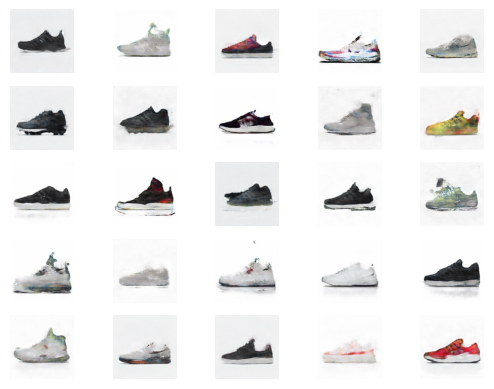

Epoch [125/300] Loss D: -156.2841, loss G: 1204.5392
Epoch [126/300] Loss D: -91.2365, loss G: 1246.5422
Epoch [127/300] Loss D: -130.3257, loss G: 1278.3862
Epoch [128/300] Loss D: -109.5330, loss G: 1182.6204
Epoch [129/300] Loss D: -106.8936, loss G: 1314.9310
Epoch [130/300] Loss D: -89.9998, loss G: 1169.8931
Epoch [131/300] Loss D: -154.4567, loss G: 1342.5853
Epoch [132/300] Loss D: -124.2449, loss G: 1185.5939
Epoch [133/300] Loss D: -71.6032, loss G: 1210.7513
Epoch [134/300] Loss D: -147.4139, loss G: 1128.0250
Epoch [135/300] Loss D: -116.5256, loss G: 1234.9703
Epoch [136/300] Loss D: -115.3962, loss G: 1181.1307
Epoch [137/300] Loss D: -123.8880, loss G: 1324.1675


In [ ]:
# gen = torch.load("../input/model-100-pt/model_100.pt").to(device) # resume training

transform = tfs.Compose(
    [
        tfs.Resize(256),
        tfs.ToTensor(),
        tfs.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        # mean and std of 0.5 normalizes between [-1, 1]. applied to all 3 channels
    ]
)

# Load dataset
dataset = ImageFolder(root="../input/sneaker-dataset", transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=True)
print("Folder loaded")

# Initialize gen and crit
gen = Generator().to(device)
crit = Critic().to(device)
initialize_weights(gen)
initialize_weights(crit)

# Initialize optimizer
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.0001, betas=(0, 0.9))
crit_opt = torch.optim.Adam(crit.parameters(), lr=0.0001, betas=(0, 0.9))

gen.train()
crit.train()

print("Training started")
for epoch in range(0, 300):
    for i, (images, _) in enumerate(loader):
        real = images.to(device)
        batch_size = real.size(0)

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        for _ in range(5):
            noise = torch.randn(batch_size, 64, 1, 1).to(device)
            fake = gen(noise)

            critic_real = crit(real).reshape(-1)
            critic_fake = crit(fake).reshape(-1) # reshape(-1) will flatten the 1x1 conv2d output
            gp = gradient_penalty(crit, real, fake, device)

            critic_loss = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + 10 * gp
            )
            crit.zero_grad()
            critic_loss.backward(retain_graph=True)
            crit_opt.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = crit(fake).reshape(-1)
        gen_loss = -torch.mean(gen_fake)

        gen.zero_grad()
        gen_loss.backward()
        gen_opt.step()

    print(f"Epoch [{epoch}/{300}] Loss D: {critic_loss:.4f}, loss G: {gen_loss:.4f}")

    if (epoch + 1) % 25 == 0:
      plot_generated_images()
      torch.save(gen, f"/kaggle/working/model_{epoch+1}.pt")


In [ ]:
print('hello')